<a href="https://colab.research.google.com/github/haguerrero/proyecto_fraudes/blob/main/proyecto_transacciones_fraudulentas_hugo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Proyecto:
##Contruir un modelo de machine learning que detecte si una transacción es fraudulenta a partir de las caracteríticas de la transacción.

Motivación del proyecto:
<p>La razón de tomar este proyecto parte de la "similitud" de la necesidad que enfrentamos en la empresa donde me encuentro trabajando.
Similitud porque trabajo en una fintech radicada en España en donde está desarrollando una aplicación móvil que inicialmente atiende el mercado español, con intensiones de expansión a otros mercados. La misma permite a usuarios retiar dinero en efectivo y realizar pagos en una red de comercios asociados, como tiendas, estancos y farmacias. La idea principal es funcionar como una alternativa a los cajeros automáticos, facilitando el acceso a efectivo en lugares más cercanos y ofreciendo incentivos como cashback y descuentos.</p>
<p>Dicho esto, y debido a la naturaleza de la compañía, era pertinente y muy necesario establecer reglas para el retiro de dinero, aunque las mismas fueron implementadas con lógica de programación, con el tiempo se han evidenciado lagunas o casos no considerados. </p>

## Preparamos google Drive para usarlo con colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importar API token kaggle.json
Es necesario subir el archivo kaggle.json para obtener el dataset.

En drive de google, se va a crear un directorio .kaggle donde se almacenará el archivo kaggle.json para descargar el dataset usado en el proyecto.

Para obtener el kaggle.json, en kaggle en el icono del usuario en la esquina superior derecha, hacer click y luego dirigirse a Settings, ir hasta la sección API y generar el archivo.

## Importar librerías

In [7]:
from google.colab import files

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt


In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hugoagg","key":"0377b89feecb1813dd7f4d0f5cdd4535"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d chitwanmanchanda/fraudulent-transactions-data

Dataset URL: https://www.kaggle.com/datasets/chitwanmanchanda/fraudulent-transactions-data
License(s): CC0-1.0
 70% 125M/178M [00:00<00:00, 1.30GB/s]
100% 178M/178M [00:00<00:00, 1.12GB/s]


In [5]:
!unzip fraudulent-transactions-data.zip

Archive:  fraudulent-transactions-data.zip
  inflating: Fraud.csv               


# Análisis del Dataframe

<h2 style="display: inline;">EDA</h2> <h4 style="display: inline; color: gray;">(Exploratory Data Analysis)</h4>

Para llevar a cabo el modelo, es necesario entender que datos tenemos en el conjunto y qué nos está indicando los datos.
Por tanto, en un principio estamos tratando con un conjunto de datos que está conformado por un archivo que tiene 6.3626.20 registros o filas y 11 columnas.
El archivo correspondiente nos indica que es una simulación de 30 días (aprox.) de simulación.

In [8]:
# Leemos el archivo y creamos el dataframe.
df = pd.read_csv('/content/Fraud.csv')

In [ ]:
# Revisamos las columnas originales
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [9]:
# Determinamos si el conjunto tiene valores faltantes.

df.isna().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [10]:
# Determinamos si existen filas duplicadas
df.duplicated().sum()

np.int64(0)

In [11]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
# Determinando si las columnas nameOrig y nameDest son relevantes
# Cuantas operaciones repiten del mismo nameOrigen al mismo nameDest
conteo_transacciones = df.groupby(['nameOrig', 'nameDest']).size()
repetidos = conteo_transacciones[conteo_transacciones > 1]
print("Transacciones de filas origen destino repetidas:", {len(repetidos)})


Transacciones de filas origen destino repetidas: {0}


In [ ]:
# Determinar si un nameOrig intenta fraude mas de una vez
conteo_orig_fraud = df.groupby('nameOrig')['isFraud'].sum()
conteo_orig_fraud = conteo_orig_fraud[conteo_orig_fraud > 1]
print("Transacciones de origen con fraude repetido:", {len(conteo_orig_fraud)})

Transacciones de origen con fraude repetido: {0}


In [ ]:
# Determinar si un nameDest intenta fraude mas de una vez
conteo_dest_fraud = df.groupby('nameDest')['isFraud'].sum()
conteo_dest_fraud = conteo_orig_fraud[conteo_orig_fraud > 1]
print("Transacciones de destino con fraude repetido:", {len(conteo_orig_fraud)})

Transacciones de destino con fraude repetido: {0}


Según el análisis, las columnas que representan la identidicación del cliente que inicia la transacción como el cliente destinatario de la transacción, es irrelevante para incluirlos como etiquetas en el modelo a entrenar, por tanto son de las columnas que podemos prescindir para el entrenamiento.

In [ ]:
# A continuación, quiero saber que proporcion representan los fraudes en el conjunto de datos
df['isFraud'].value_counts(normalize=True)

,proportion
isFraud,
0,0.998709
1,0.001291


In [ ]:
# Otra manera, quiero saber cuantas operaciones de fraudes tenemos en el conjunto de datos.
df['isFraud'].value_counts()

,count
isFraud,
0,6354407
1,8213


En este punto, tenemos claridad que estamos ante un caso de datos muy desbalanceados y debido a la naturaleza que representa el conjunto es muy consistente con la realidad, debido a que en el ámbito de un entorno financiero, las operaciones licitas son las mas abundantes, sino el negocio en sí no tendría sentido alguno.

In [ ]:
# intento constatar que tan frecuente ocurre una operación de fraude, aproximandamente cada 773 operaciones.
frecuencia = 6354407/8213
print(frecuencia)
print(0.998709/0.001291)

773.7010836478753
773.5933384972889


In [ ]:
# Cantidad de tipos de transacciones (cuantas operaciones representan cada tipo).
df['type'].value_counts()

,count
type,
CASH_OUT,2237500
PAYMENT,2151495
CASH_IN,1399284
TRANSFER,532909
DEBIT,41432


In [ ]:
# Cantidad de fraudes por tipo de transaccion
df.groupby(['type', 'isFraud']).size()

type      isFraud
CASH_IN   0          1399284
CASH_OUT  0          2233384
          1             4116
DEBIT     0            41432
PAYMENT   0          2151495
TRANSFER  0           528812
          1             4097
dtype: int64

In [ ]:
# Sumando las operaciones de fraude en CASH_OUT y en TRANSFER
suma_operaciones_fraude = 4116 + 4097
print('Número de operaciones fraudulentas: ',suma_operaciones_fraude)

Número de operaciones fraudulentas:  8213


In [ ]:
df['type'].value_counts()

,count
type,
CASH_OUT,2237500
PAYMENT,2151495
CASH_IN,1399284
TRANSFER,532909
DEBIT,41432


In [ ]:
# Elimino la columna isFlaggedFraud que no me aporta nada para el modelo.
df.drop('isFlaggedFraud', axis=1, inplace=True)

In [ ]:
# Debido al desbalance de los datos, quiero ver que diferencia hay en las transacciones con fraudes a las legitimas
df_legitimas = df[df['isFraud'] == 0]
df_fraud = df[df['isFraud'] == 1]

In [ ]:
df_legitimas.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0
5,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0
6,1,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,0


In [ ]:
df_fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1


In [ ]:
df_noName_type_splited = pd.get_dummies(df, columns=['type'], drop_first=True)
print('Data Frame con type segmentado:\n')
df_noName_type_splited

Data Frame con type segmentado:



,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,False,False,True,False
1,1,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,False,False,True,False
2,1,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,False,False,False,True
3,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,True,False,False,False
4,1,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,True,False,False,False
6362616,743,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,False,False,False,True
6362617,743,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,True,False,False,False
6362618,743,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,False,False,False,True


En este punto desconozco si quitando las columnas relacionadas con balances debo quitarlas o existe un patron en los valores que ayuden a determinar el fraude en si.

Decido continuar con los valores e ir descubriendolo con el avance.

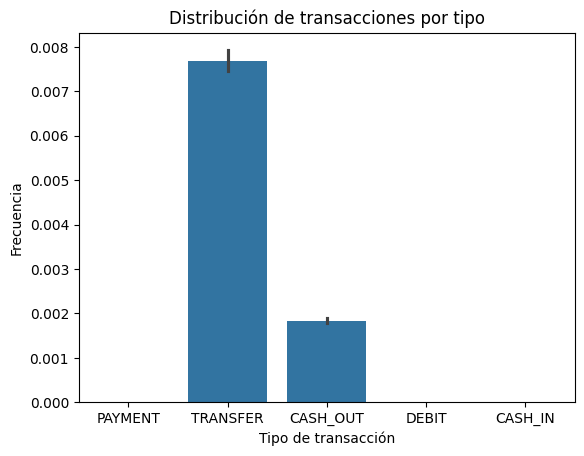

In [ ]:
sns.barplot(data=df, x='type', y='isFraud')
plt.xlabel('Tipo de transacción')
plt.ylabel('Frecuencia')
plt.title('Distribución de transacciones por tipo')
plt.show()

In [ ]:
# Elimino las columnas de relacionadas con los nombres

df_noName = df_noName_type_splited.drop(columns=['nameOrig', 'nameDest'])
df_noName

NameError: name 'df_noName_type_splited' is not defined

## Etiquetas y Target

In [ ]:
X = df_noName.drop('isFraud', axis=1) # label
y = df_noName['isFraud'] # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Entrenando Modelos

In [ ]:
# Modelando con RandomForestClassifier

clf = RandomForestClassifier(class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

KeyboardInterrupt: 

## Oversampling
Para tratar de mejorar el Recall, tratare de balancear un poco mas los datos, hace oversampling y analizar como nos puede ayudar este metodo para modelos desbalanceados

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Evaluar la diferencia después de SMOTE
print(f"Distribución de clases antes de SMOTE: {y_train.value_counts()}")
print(f"Distribución de clases después de SMOTE: {y_train_resampled.value_counts()}")

Distribución de clases antes de SMOTE: isFraud
0    5083503
1       6593
Name: count, dtype: int64
Distribución de clases después de SMOTE: isFraud
0    5083503
1    5083503
Name: count, dtype: int64


## Entrenado con datos Balanceados

In [ ]:
clf.fit(X_train_resampled, y_train_resampled)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))



KeyboardInterrupt: 

## Intentare probar el rendimiento con otro modelo de entrenamiento
### XGBClassifier

In [ ]:
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train_resampled, y_train_resampled)

# Predecir con datos originales
y_pred = xgb_clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:26:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.36      0.99      0.53      1620

    accuracy                           1.00   1272524
   macro avg       0.68      1.00      0.76   1272524
weighted avg       1.00      1.00      1.00   1272524

[[1268054    2850]
 [     10    1610]]


In [ ]:
# intento ver que mejora con un umbral de 0.7
y_proba = xgb_clf.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_proba >= 0.7).astype(int)

print(classification_report(y_test, y_pred_thresh))
print(confusion_matrix(y_test, y_pred_thresh))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.44      0.99      0.61      1620

    accuracy                           1.00   1272524
   macro avg       0.72      0.99      0.80   1272524
weighted avg       1.00      1.00      1.00   1272524

[[1268840    2064]
 [     19    1601]]


In [ ]:
# He ido variando el umbral hasta notar un equilibrio con 0.9
y_proba = xgb_clf.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_proba >= 0.99).astype(int)

print(classification_report(y_test, y_pred_thresh))
print(confusion_matrix(y_test, y_pred_thresh))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.91      0.91      0.91      1620

    accuracy                           1.00   1272524
   macro avg       0.96      0.96      0.96   1272524
weighted avg       1.00      1.00      1.00   1272524

[[1270762     142]
 [    145    1475]]


In [ ]:
thresholds = []
precisions = []
recalls = []
f1s = []

# Ejemplo de bucle para calcular las métricas en varios umbrales
for threshold in np.arange(0.5, 1.01, 0.01):
    y_pred_thresholded = (y_proba >= threshold).astype(int)
    p = precision_score(y_test, y_pred_thresholded)
    r = recall_score(y_test, y_pred_thresholded)
    f1 = f1_score(y_test, y_pred_thresholded)

    thresholds.append(threshold)
    precisions.append(p)
    recalls.append(r)
    f1s.append(f1)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


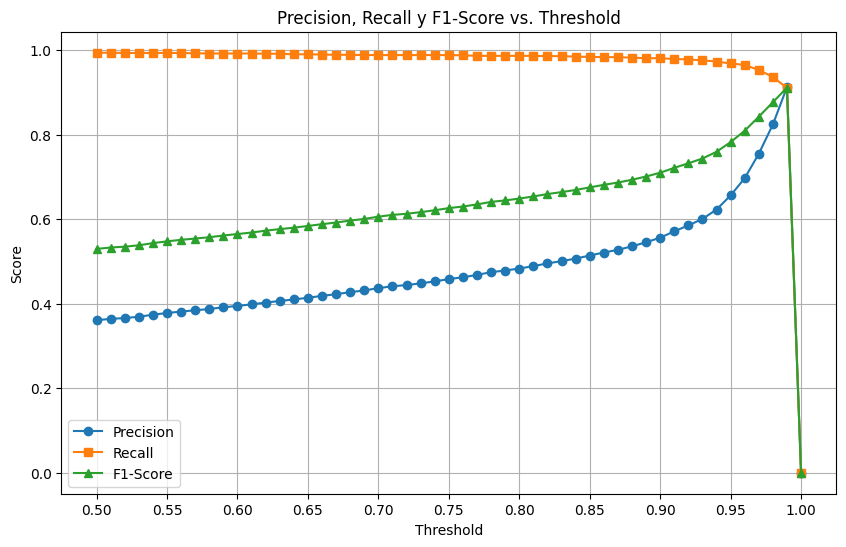

In [ ]:
# Gráfica
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision", marker='o')
plt.plot(thresholds, recalls, label="Recall", marker='s')
plt.plot(thresholds, f1s, label="F1-Score", marker='^')

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall y F1-Score vs. Threshold")
plt.grid(True)
plt.legend()
plt.xticks(np.arange(0.5, 1.01, 0.05))
plt.show()

## Graficando la Curva ROC

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

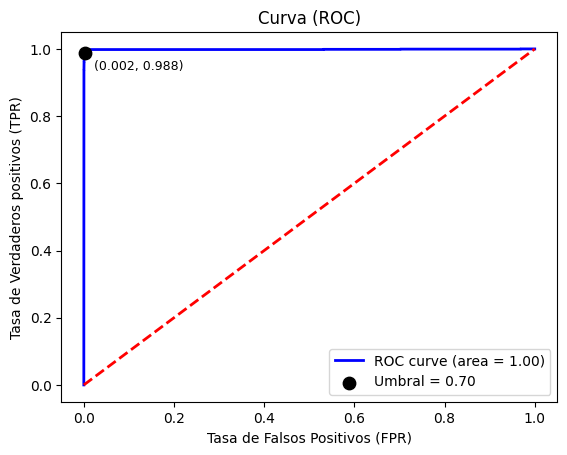

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')

umbral = 0.7
idx_umbral = np.argmin(np.abs(thresholds - umbral))
plt.scatter(fpr[idx_umbral], tpr[idx_umbral], marker='o', color='black', s=80, zorder=5, label=f'Umbral = {umbral:.2f}')

plt.annotate(f"({fpr[idx_umbral]:.3f}, {tpr[idx_umbral]:.3f})",
             (fpr[idx_umbral]+0.02, tpr[idx_umbral]-0.05),
             fontsize=9, color='black')

plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos positivos (TPR)')
plt.title('Curva (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
correlaciones = df_noName.corr()['isFraud'].sort_values(ascending=False)
print(correlaciones.head(20))

isFraud           1.000000
amount            0.076688
type_TRANSFER     0.053869
step              0.031578
type_CASH_OUT     0.011256
oldbalanceOrg     0.010154
newbalanceDest    0.000535
type_DEBIT       -0.002911
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
type_PAYMENT     -0.025697
Name: isFraud, dtype: float64


## Ahora pruebo pero sin newbalanceorig y newbalanceDest

In [ ]:
# antes de eliminar las columnas newbalanceOrig y newbalanceDest
df_noName

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.00,160296.36,0.00,0.00,0,False,False,True,False
1,1,1864.28,21249.00,19384.72,0.00,0.00,0,False,False,True,False
2,1,181.00,181.00,0.00,0.00,0.00,1,False,False,False,True
3,1,181.00,181.00,0.00,21182.00,0.00,1,True,False,False,False
4,1,11668.14,41554.00,29885.86,0.00,0.00,0,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,339682.13,0.00,0.00,339682.13,1,True,False,False,False
6362616,743,6311409.28,6311409.28,0.00,0.00,0.00,1,False,False,False,True
6362617,743,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,True,False,False,False
6362618,743,850002.52,850002.52,0.00,0.00,0.00,1,False,False,False,True


In [ ]:
# Eliminamos newbalanceOrig y newbalanceDest y lo hacemos desde el último DF pulido.
df_NoNewBalance = df_noName.drop(columns=['newbalanceOrig', 'newbalanceDest'])

#
X2 = df_NoNewBalance.drop('isFraud', axis=1) #labels
y2 = df_NoNewBalance['isFraud'] #target

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)

# Nuevo oversampling (SMOTE)

smote2 = SMOTE(random_state=42)
X2_train_resampled, y2_train_resampled = smote2.fit_resample(X2_train, y2_train)

# Entrenamos de nuevo pero con XGBClassifier

xgb2_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb2_clf.fit(X2_train_resampled, y2_train_resampled)

# Predecir con datos originales
y2_pred = xgb2_clf.predict(X2_test)

print(classification_report(y2_test, y2_pred))
print(confusion_matrix(y2_test, y2_pred))

y2_proba = xgb2_clf.predict_proba(X2_test)[:, 1]
y2_pred_thresh = (y2_proba >= 0.99).astype(int)

print(classification_report(y2_test, y2_pred_thresh))
print(confusion_matrix(y2_test, y2_pred_thresh))



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:37:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270881
           1       0.20      0.99      0.34      1643

    accuracy                           0.99   1272524
   macro avg       0.60      0.99      0.67   1272524
weighted avg       1.00      0.99      1.00   1272524

[[1264521    6360]
 [     15    1628]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.88      0.83      0.86      1643

    accuracy                           1.00   1272524
   macro avg       0.94      0.92      0.93   1272524
weighted avg       1.00      1.00      1.00   1272524

[[1270689     192]
 [    272    1371]]


In [ ]:
# Eliminamos oldbalanceOrg	newbalanceOrig	oldbalanceDest	newbalanceDest
df_NoBalance = df_noName.drop(columns=['newbalanceOrig', 'newbalanceDest', 'oldbalanceOrg', 'oldbalanceDest'])

#
X3 = df_NoBalance.drop('isFraud', axis=1) #labels
y3 = df_NoBalance['isFraud'] #target

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42, stratify=y3)

# Nuevo oversampling (SMOTE)

smote2 = SMOTE(random_state=42)
X3_train_resampled, y3_train_resampled = smote2.fit_resample(X3_train, y3_train)

# Entrenamos de nuevo pero con XGBClassifier

xgb3_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb3_clf.fit(X3_train_resampled, y3_train_resampled)

# Predecir con datos originales
y3_pred = xgb3_clf.predict(X3_test)

print(classification_report(y3_test, y3_pred))
print(confusion_matrix(y3_test, y3_pred))

y3_proba = xgb3_clf.predict_proba(X3_test)[:, 1]
y3_pred_thresh = (y3_proba >= 0.98).astype(int)

print(classification_report(y3_test, y3_pred_thresh))
print(confusion_matrix(y2_test, y2_pred_thresh))
tn, fp, fn, tp = confusion_matrix(y3_test, y3_pred_thresh).ravel()
print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:39:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1270881
           1       0.02      0.82      0.05      1643

    accuracy                           0.96   1272524
   macro avg       0.51      0.89      0.51   1272524
weighted avg       1.00      0.96      0.98   1272524

[[1218055   52826]
 [    299    1344]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.56      0.38      0.46      1643

    accuracy                           1.00   1272524
   macro avg       0.78      0.69      0.73   1272524
weighted avg       1.00      1.00      1.00   1272524

True Negatives: 1270388, False Positives: 493, False Negatives: 1011, True Positives: 632


## Realizando Feature Engineering


In [ ]:
# Eliminamos oldbalanceOrg	newbalanceOrig	oldbalanceDest	newbalanceDest
# Feature engineering
df_noName['Origin'] = df_noName['oldbalanceOrg'] - df_noName['newbalanceOrig']
df_noName['Destiny'] = df_noName['newbalanceDest'] - df_noName['oldbalanceDest']

# Transformar los boolean a digitos
df_noName[['type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']] = \
df_noName[['type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']].astype(int)

df_NoBalance = df_noName.drop(columns=['newbalanceOrig', 'newbalanceDest', 'oldbalanceOrg', 'oldbalanceDest'])

df_NoBalance

,step,amount,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,Origin,Destiny
0,1,9839.64,0,0,0,1,0,9839.64,0.00
1,1,1864.28,0,0,0,1,0,1864.28,0.00
2,1,181.00,1,0,0,0,1,181.00,0.00
3,1,181.00,1,1,0,0,0,181.00,-21182.00
4,1,11668.14,0,0,0,1,0,11668.14,0.00
...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,1,1,0,0,0,339682.13,339682.13
6362616,743,6311409.28,1,0,0,0,1,6311409.28,0.00
6362617,743,6311409.28,1,1,0,0,0,6311409.28,6311409.27
6362618,743,850002.52,1,0,0,0,1,850002.52,0.00


In [ ]:

X4 = df_NoBalance.drop('isFraud', axis=1) #labels
y4 = df_NoBalance['isFraud'] #target

X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42, stratify=y4)

# Nuevo oversampling (SMOTE)

smote4 = SMOTE(random_state=42)
X4_train_resampled, y4_train_resampled = smote4.fit_resample(X4_train, y4_train)

# Entrenamos de nuevo pero con XGBClassifier

xgb4_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb4_clf.fit(X4_train_resampled, y4_train_resampled)

# Predecir con datos originales
y4_pred = xgb4_clf.predict(X4_test)

print(classification_report(y4_test, y4_pred))
print(confusion_matrix(y4_test, y4_pred))

y4_proba = xgb4_clf.predict_proba(X4_test)[:, 1]
y4_pred_thresh = (y4_proba >= 0.988).astype(int)

print(classification_report(y4_test, y4_pred_thresh))
print(confusion_matrix(y4_test, y4_pred_thresh))
tn, fp, fn, tp = confusion_matrix(y4_test, y4_pred_thresh).ravel()
print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:13:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       1.00      0.97      0.99   1270881
           1       0.05      0.97      0.09      1643

    accuracy                           0.97   1272524
   macro avg       0.52      0.97      0.54   1272524
weighted avg       1.00      0.97      0.99   1272524

[[1238869   32012]
 [     50    1593]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.84      0.81      0.82      1643

    accuracy                           1.00   1272524
   macro avg       0.92      0.90      0.91   1272524
weighted avg       1.00      1.00      1.00   1272524

[[1270637     244]
 [    319    1324]]
True Negatives: 1270637, False Positives: 244, False Negatives: 319, True Positives: 1324


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


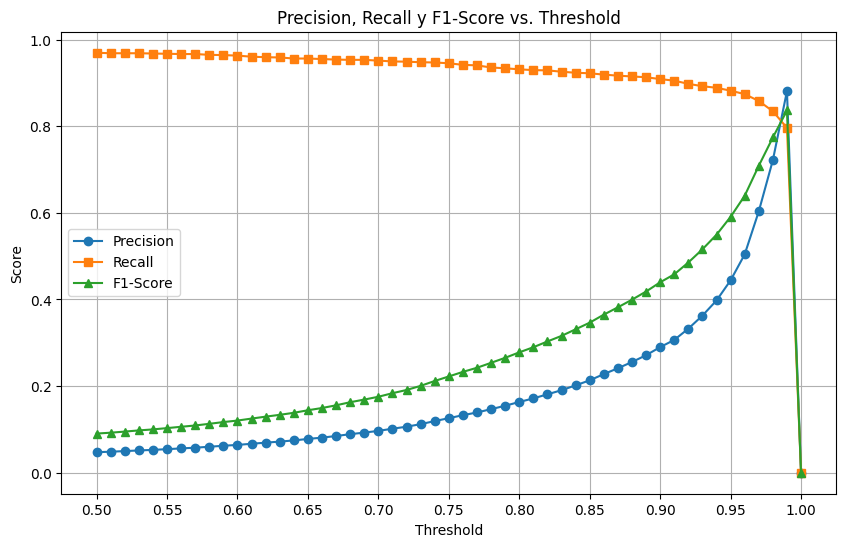

In [ ]:
# Ubicar el punto optimo de precision / recall

thresholds = []
precisions = []
recalls = []
f1s = []

# Ejemplo de bucle para calcular las métricas en varios umbrales
for threshold in np.arange(0.5, 1.01, 0.01):
    y_pred_thresholded = (y4_proba >= threshold).astype(int)
    p = precision_score(y4_test, y_pred_thresholded)
    r = recall_score(y4_test, y_pred_thresholded)
    f1 = f1_score(y4_test, y_pred_thresholded)

    thresholds.append(threshold)
    precisions.append(p)
    recalls.append(r)
    f1s.append(f1)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision", marker='o')
plt.plot(thresholds, recalls, label="Recall", marker='s')
plt.plot(thresholds, f1s, label="F1-Score", marker='^')

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall y F1-Score vs. Threshold")
plt.grid(True)
plt.legend()
plt.xticks(np.arange(0.5, 1.01, 0.05))
plt.show()

# Evaluando la diferencia entre Label encoder respecto a one-hot

In [ ]:
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,3,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0
1,1,3,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0
2,1,4,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1
3,1,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1
4,1,3,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...
6362615,743,1,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1
6362616,743,4,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1
6362617,743,1,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1
6362618,743,4,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1


In [ ]:
df_label_type = df.drop(columns=['nameOrig', 'nameDest'])

# Eliminamos oldbalanceOrg	newbalanceOrig	oldbalanceDest	newbalanceDest
# Feature engineering
df_label_type['Origin'] = df_label_type['oldbalanceOrg'] - df_label_type['newbalanceOrig']
df_label_type['Destiny'] = df_label_type['newbalanceDest'] - df_label_type['oldbalanceDest']

df_cleaned = df_label_type.drop(columns=['newbalanceOrig', 'newbalanceDest', 'oldbalanceOrg', 'oldbalanceDest'])

df_cleaned

,step,type,amount,isFraud,Origin,Destiny
0,1,3,9839.64,0,9839.64,0.00
1,1,3,1864.28,0,1864.28,0.00
2,1,4,181.00,1,181.00,0.00
3,1,1,181.00,1,181.00,-21182.00
4,1,3,11668.14,0,11668.14,0.00
...,...,...,...,...,...,...
6362615,743,1,339682.13,1,339682.13,339682.13
6362616,743,4,6311409.28,1,6311409.28,0.00
6362617,743,1,6311409.28,1,6311409.28,6311409.27
6362618,743,4,850002.52,1,850002.52,0.00


In [ ]:
X = df_cleaned.drop('isFraud', axis=1) #labels
y = df_cleaned['isFraud'] #target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
smote = SMOTE(sampling_strategy=0.05, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
!nvidia-smi

Mon Aug 11 16:34:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P0             27W /   70W |     102MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:

# Entrenamos de nuevo con XGBClassifier

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='aucpr',
                        tree_method='hist',
                        device='cuda',
                        n_estimators=300,
                        max_depth=6,
                        learning_rate=0.1,
                        )

# Entrenamos
xgb_clf.fit(X_train_resampled, y_train_resampled)

# Predecir con datos originales
y_pred = xgb_clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

y_pred_thresh = (y_proba >= 0.749).astype(int)

print(classification_report(y_test, y_pred_thresh))
print(confusion_matrix(y_test, y_pred_thresh))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:18:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.34      0.89      0.50      1643

    accuracy                           1.00   1272524
   macro avg       0.67      0.94      0.75   1272524
weighted avg       1.00      1.00      1.00   1272524

[[1268085    2796]
 [    182    1461]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.63      0.83      0.72      1643

    accuracy                           1.00   1272524
   macro avg       0.81      0.91      0.86   1272524
weighted avg       1.00      1.00      1.00   1272524

[[1270074     807]
 [    279    1364]]
True Negatives: 1270074, False Positives: 807, False Negatives: 279, True Positives: 1364
